In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 513.77it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8226.13it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [3]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,CLEAN_PATH,REF_PATH,CLEAN_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=5000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 7997.25it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 132.14it/s]


data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (667, 10) (573, 10) (667, 10) (573, 10)
conf1 (10710, 10) (667, 10) (10710, 10) (667, 10)
data1_index or data2_index is None
conf1 (667, 10) (2, 10) (667, 10) (2, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (10710, 10) (3, 10) (10710, 10) (3, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (97, 10) (2, 10) (97, 10) (2, 10)
conf1 (2, 10) (573, 10) (2, 10) (573, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (3, 10) (573, 10) (3, 10) (573, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (3, 10) (2, 10) (3, 10) (2, 10)
data1_index or data2_ind

In [47]:
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)
##### eval

# init_data = tar_provider.train_representation(TAR_EPOCH)
input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH), ref_features),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH), tar_features),axis=0)
data_loader_b = DataLoaderInit(input_X, input_Y)
data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH))
dataloader = data_loader.get_data_loader()
dataloader_b = data_loader_b.get_data_loader()


In [57]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss

# def earth_movers_distance(X, Y):
    
#     X, Y = X.detach().numpy(), Y.detach().numpy()
#     distance_matrix = cdist(X, Y)
#     first_histogram = np.ones(X.shape[0]) / X.shape[0]
#     second_histogram = np.ones(Y.shape[0]) / Y.shape[0]
#     return emd(first_histogram, second_histogram, distance_matrix)



def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())
    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 1e-5

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader_b: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)
        transformed_X = autoencoder.decoder(data_X)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_X) + 10 * topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-3)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        loss = loss_f_decoder + loss_f_encoder + 0.01 * pred_loss + cka_loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Store the predictions of unlabelled data
        # with torch.no_grad():
        #     unlabelled_pred = torch.abs(torch.Tensor(tar_provider.get_pred(TAR_EPOCH, recon_X.detach().numpy())) - torch.Tensor(tar_provider.get_pred(TAR_EPOCH, data_Y.detach().numpy()))).mean(dim=1).detach().cpu().numpy()
        #     # print("unlabelled_pred",unlabelled_pred)
        #     unlabelled_preds.extend(list(unlabelled_pred))
    
     # Identify samples with low prediction 
     #  and add them to the labelled dataset
    # num_query_samples = 100
    # unlabelled_indices = np.arange(len(unlabelled_preds))
    # query_indices = unlabelled_indices[np.argsort(unlabelled_preds)[:num_query_samples]]
    # query_preds = np.array(unlabelled_preds)[query_indices]
    # query_data_X = torch.Tensor(np.array(paired_dataset.data_X)[query_indices])
    # query_data_Y = torch.Tensor(np.array(paired_dataset.data_Y)[query_indices])
    # query_data_labels = torch.ones(num_query_samples) # Assign a label of 1 to the selected samples
    # print("query_indices",query_indices)

    # Add the selected samples to the labelled dataset
    # labelled_dataset.add_data(query_data_X, query_data_Y, query_data_labels)

    # # Create a new dataloader with the updated labelled dataset
    # labelled_loader = DataLoader(labelled_dataset, batch_size=32, shuffle=True)


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/cak_1v1.pth")


100%|██████████| 1/1 [00:00<00:00, 3666.35it/s]

In [15]:

X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_2 = alignment_n.align_embeddings_batch(Y,X,train_steps=2000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 65502392.0 loss2 {tensor(0.7834, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8510, requires_grad=True)}
batch_idx 199,iteration 199, loss1 592.7222900390625 loss2 {tensor(0.5366, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4920, requires_grad=True)}
batch_idx 398,iteration 398, loss1 236.24374389648438 loss2 {tensor(0.3439, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4660, requires_grad=True)}
batch_idx 97,iteration 597, loss1 216.66461181640625 loss2 {tensor(0.3112, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4190, requires_grad=True)}
batch_idx 296,iteration 796, loss1 228.19483947753906 loss2 {tensor(0.3359, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4140, requires_grad=True)}
batch_idx 495,iteration 995, loss1 205.9328155517578 loss2 {tensor(0.2813, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3770, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 191.8606414794922 loss2 {tensor(0.2756, grad_fn=<AddBackward0>)} neibour_

In [50]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between  target vs target is:         ',np_cka.kernel_CKA(Y[indicates],Y[indicates]))
# print('CKA between target and linear_target:     ',np_cka.kernel_CKA(Y[indicates],np.dot(Y[indicates],R_n_2.detach().numpy())))
print('CKA between target and autoencoder_target:',np_cka.kernel_CKA(Y[indicates],c_y[indicates]))
print('CKA between  ref vs autoencoder_target is:',np_cka.kernel_CKA(X[indicates],c_y[indicates]))
print('CKA between  ref vs target is:            ',np_cka.kernel_CKA(X[indicates],c_y[indicates]))

CKA between  target vs target is:          1.0
CKA between target and autoencoder_target: 0.9864951566753207
CKA between  ref vs autoencoder_target is: 0.8428445158253453
CKA between  ref vs target is:             0.8428445158253453


In [25]:
low_conf = []
high_conf = []
for i in range(len(tar_scores)):
    if tar_scores[i] < 0.995:
        low_conf.append(i)
    if tar_scores[i] == 1:
        high_conf.append(i)
len(low_conf)

623

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8915.78it/s]


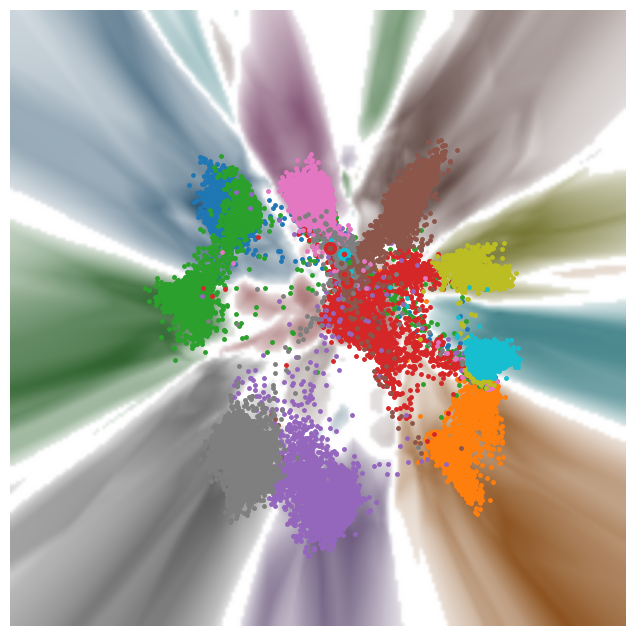

In [14]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, tar_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 6561.10it/s]


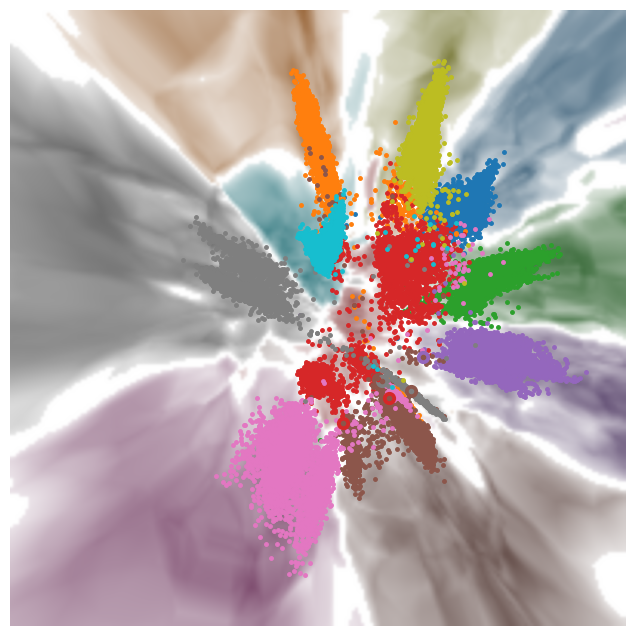

In [56]:
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/add_Real_70000boundary.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVisAutoEncoder.visualizer_ import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [64]:
embedding1 = projector.batch_project(200, encoded_Y.detach().numpy())
embedding2 = projector.batch_project(200, ref_provider.train_representation(200))

100%|██████████| 25/25 [00:00<00:00, 11989.21it/s]

#train# PPR: 0.09 in epoch 200


In [65]:
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 2
output_dim = 2

autoencoder_for_2d = SimpleAutoencoder(input_dim,output_dim)

In [76]:
# Training loop
data_Y = torch.Tensor(embedding1)
data_X = torch.Tensor(embedding2)
for epoch in range(num_epochs):

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder_for_2d.encoder(data_Y)
        recon_X = autoencoder_for_2d.decoder(transformed_Y)


        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_Y) 
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) 



        loss = loss_f_decoder + loss_f_encoder 

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f}')


Epoch [1/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [2/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [3/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [4/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [5/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [6/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [7/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [8/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [9/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142
Epoch [10/10], Loss: 0.0257, Loss decoder: 0.0115,Loss encoder: 0.0142


Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9148.18it/s]
../AlignVisAutoEncoder/visualizer.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
../AlignVisAutoEncoder/visualizer.py:192: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
../AlignVisAutoEncoder/visualizer.py:193: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|█

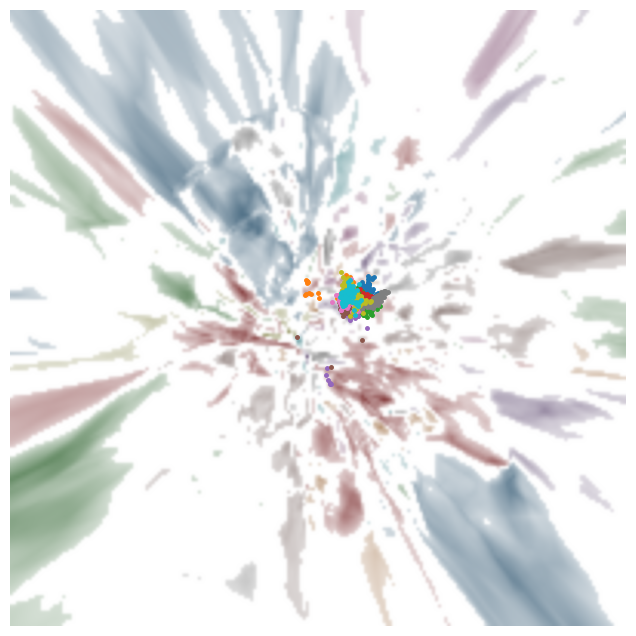

In [54]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[high_conf[:600]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 8737.77it/s]
../AlignVisAutoEncoder/trans_visualizer.py:189: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../AlignVisAutoEncoder/trans_visualizer.py:190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../AlignVisAutoEncoder/trans_visualizer.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` i

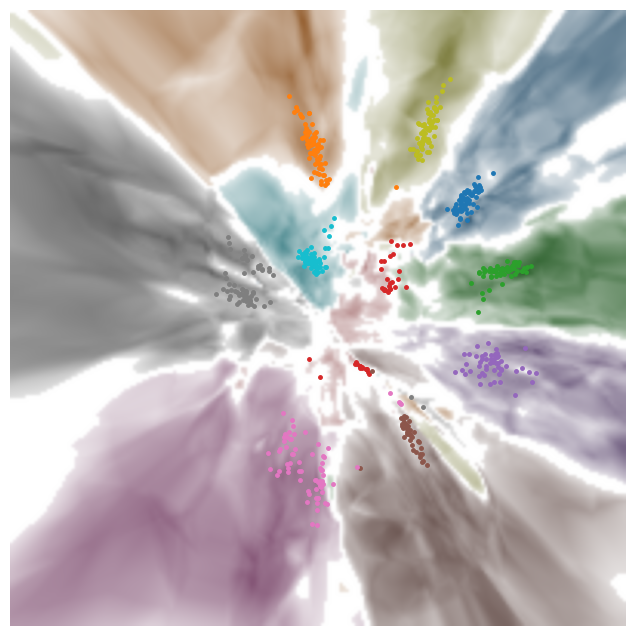

In [48]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[high_conf[:600]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8337.45it/s]


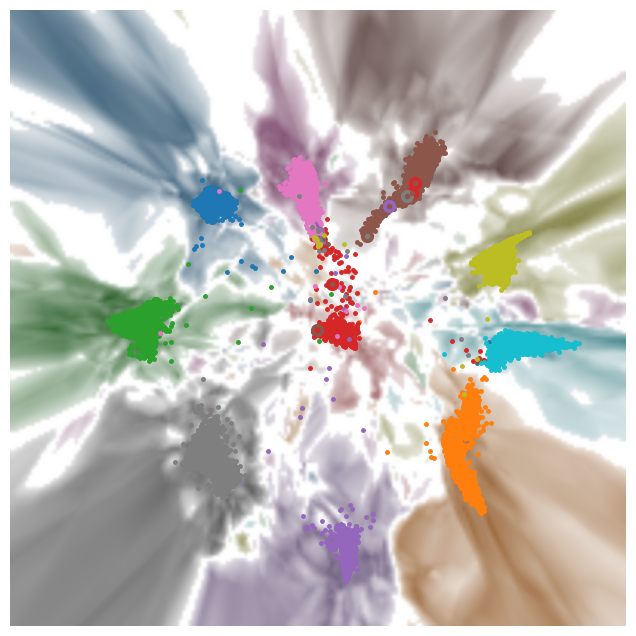

In [22]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [15]:
from AlignVis_eval.AlignViseval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)

In [16]:
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 3.89/15 in epoch 200


3.89388

In [85]:

X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_2 = alignment_n.align_embeddings_batch(Y,X,train_steps=2000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 65367516.0 loss2 {tensor(0.6277, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8270, requires_grad=True)}
batch_idx 199,iteration 199, loss1 1126.5791015625 loss2 {tensor(0.6471, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6190, requires_grad=True)}
batch_idx 398,iteration 398, loss1 268.49554443359375 loss2 {tensor(0.4852, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5740, requires_grad=True)}
batch_idx 97,iteration 597, loss1 207.60659790039062 loss2 {tensor(0.4076, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5470, requires_grad=True)}
batch_idx 296,iteration 796, loss1 248.89566040039062 loss2 {tensor(0.4966, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5410, requires_grad=True)}
batch_idx 495,iteration 995, loss1 270.5224609375 loss2 {tensor(0.4901, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5480, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 174.88636779785156 loss2 {tensor(0.3384, grad_fn=<AddBackward0>)} neibour_loss

In [12]:
eval.eval_boundary_nn_linear(tar_features,R_n_2.detach().numpy())

#train# boundary preserving for linear: 2.09/15 in epoch 200


2.09272

In [11]:
eval.eval_boundary_nn_ref_in_ref(ref_features)

#train# boundary preserving: 2.31/15 in epoch 200


2.31254

In [84]:
eval.eval_boundary_nn_tar_in_ref(tar_features)

#train# boundary preserving: 0.78/15 in epoch 100


0.78056

In [93]:
eval.eval_nn_train_autoencoder(15,autoencoder)

Sun Apr  9 21:46:34 2023 Building RP forest with 16 trees
Sun Apr  9 21:46:35 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun Apr  9 21:46:36 2023 Building RP forest with 16 trees
Sun Apr  9 21:46:36 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.48/15 in epoch 100


1.47728

In [120]:
##### eval reference 

init_data = ref_provider.train_representation(REF_EPOCH)

embedding = projector.batch_project(REF_EPOCH, init_data)
ref_val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for ref in ref vis: {:.2f}/{:d} in epoch {:d}".format(ref_val, n_neighbors, REF_EPOCH))


Sun Apr  9 01:46:08 2023 Building RP forest with 16 trees
Sun Apr  9 01:46:09 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr  9 01:46:10 2023 Building RP forest with 16 trees
Sun Apr  9 01:46:11 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for ref in ref vis: 1.22/15 in epoch 200


In [93]:
##### eval reference timevis visualize tar_representation

init_data = tar_provider.train_representation(REF_EPOCH)

embedding = projector.batch_project(REF_EPOCH, init_data)
val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for tar in ref vis: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, REF_EPOCH))


Sun Apr  9 00:59:09 2023 Building RP forest with 16 trees
Sun Apr  9 00:59:10 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr  9 00:59:11 2023 Building RP forest with 16 trees
Sun Apr  9 00:59:11 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for tar in ref vis: 1.07/15 in epoch 200


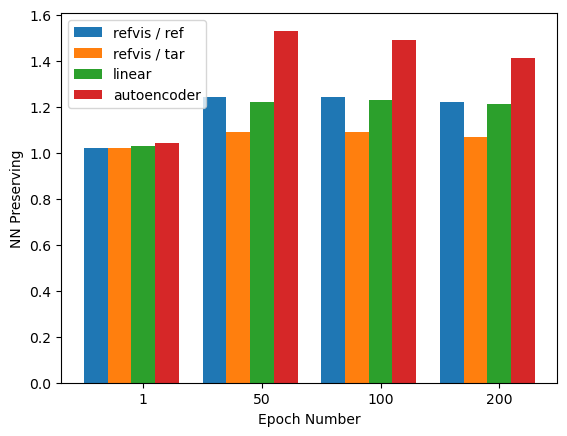

In [98]:
##### with predcition loss
import numpy as np
import matplotlib.pyplot as plt

size = 4
name_list = ["1","50","100","200"]
x = np.arange(size)
a = [1.02,1.24,1.24,1.22]
b = [1.03,1.22,1.23,1.21]

c = [1.04,1.53,1.49,1.40]

d = [1.02,1.09,1.09,1.07]

total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2
plt.xlabel('Epoch Number')
plt.ylabel('NN Preserving')
plt.bar(x, a,  width=width, label='refvis / ref')
plt.bar(x + width, d,  width=width, label='refvis / tar')
plt.bar(x + 2 * width, b, width=width, label='linear',tick_label=name_list)
plt.bar(x + 3 * width, c, width=width, label='autoencoder')
plt.legend()
plt.show()


In [98]:
##### eval
init_data = tar_provider.train_representation(TAR_EPOCH)
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 15

train_data = np.dot(init_data,R_n_2.detach().numpy())
embedding = projector.batch_project(REF_EPOCH, train_data)
linear_val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving: {:.2f}/{:d} in epoch {:d}".format(linear_val, n_neighbors, TAR_EPOCH))


Sat Apr  8 22:30:24 2023 Building RP forest with 16 trees
Sat Apr  8 22:30:25 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Apr  8 22:30:26 2023 Building RP forest with 16 trees
Sat Apr  8 22:30:26 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.22/15 in epoch 50


In [30]:

train_data = encoded_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = autoencoder.decoder(torch.Tensor(inv_data))
new_inv = new_inv.detach().numpy()
####### target prediction
pred = tar_provider.get_pred(TAR_EPOCH, tar_provider.train_representation(TAR_EPOCH)).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# autoencoder PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 8290.91it/s]

#train# autoencoder PPR: 0.92 in epoch 200


In [45]:
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/add_Real_70000boundary.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
encoded_Y_grid = autoencoder.encoder(torch.Tensor(input_Y))
train_data = encoded_Y_grid.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = autoencoder.decoder(torch.Tensor(inv_data))
new_inv = new_inv.detach().numpy()
####### target prediction
pred = tar_provider.get_pred(TAR_EPOCH, input_Y).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# autoencoder PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 275/275 [00:00<00:00, 7807.45it/s]

#train# autoencoder PPR: 0.93 in epoch 200


In [46]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between  target vs target is:         ',np_cka.kernel_CKA(Y[indicates],Y[indicates]))
# print('CKA between target and linear_target:     ',np_cka.kernel_CKA(Y[indicates],np.dot(Y[indicates],R_n_2.detach().numpy())))
print('CKA between target and autoencoder_target:',np_cka.kernel_CKA(Y[indicates],c_y[indicates]))
print('CKA between  ref vs autoencoder_target is:',np_cka.kernel_CKA(X[indicates],c_y[indicates]))
print('CKA between  ref vs target is:            ',np_cka.kernel_CKA(X[indicates],c_y[indicates]))

CKA between  target vs target is:          1.0000000000000002
CKA between target and autoencoder_target: 0.9996101997831619
CKA between  ref vs autoencoder_target is: 0.8305176445731264
CKA between  ref vs target is:             0.8305176445731264


In [81]:
REF_EPOCH = 50
TAR_EPOCH = 50
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_2 = alignment_n.align_embeddings_batch(Y,X,train_steps=1000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 80207328.0 loss2 {tensor(0.6497, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8440, requires_grad=True)}
batch_idx 199,iteration 199, loss1 1094.748046875 loss2 {tensor(0.7445, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7130, requires_grad=True)}
batch_idx 398,iteration 398, loss1 390.6304626464844 loss2 {tensor(0.5552, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6330, requires_grad=True)}
batch_idx 97,iteration 597, loss1 317.4765625 loss2 {tensor(0.5515, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6090, requires_grad=True)}
batch_idx 296,iteration 796, loss1 328.29412841796875 loss2 {tensor(0.5411, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6330, requires_grad=True)}
batch_idx 495,iteration 995, loss1 311.1195983886719 loss2 {tensor(0.4333, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6080, requires_grad=True)}


In [82]:

X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
S_n = alignment_n.align_embeddings_batch(X,Y,train_steps=1000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 98238056.0 loss2 {tensor(0.6130, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8200, requires_grad=True)}
batch_idx 199,iteration 199, loss1 1491.0352783203125 loss2 {tensor(0.8029, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7100, requires_grad=True)}
batch_idx 398,iteration 398, loss1 586.6943969726562 loss2 {tensor(0.6765, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6500, requires_grad=True)}
batch_idx 97,iteration 597, loss1 299.1494445800781 loss2 {tensor(0.5408, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5730, requires_grad=True)}
batch_idx 296,iteration 796, loss1 209.17984008789062 loss2 {tensor(0.4197, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5460, requires_grad=True)}
batch_idx 495,iteration 995, loss1 188.90074157714844 loss2 {tensor(0.3430, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5240, requires_grad=True)}


In [83]:
############# linear transfimrtaion PPR
train_data = np.dot(tar_provider.train_representation(REF_EPOCH), R_n_2.detach().numpy())
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = np.dot(inv_data, S_n.detach().numpy())
# new_inv = new_inv.detach().numpy()
pred = tar_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# linear PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 8100.68it/s]

#train# linear PPR: 0.14 in epoch 50


In [109]:
REF_EPOCH = 1
TAR_EPOCH = 1
train_data = ref_provider.train_representation(REF_EPOCH)
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)

pred = ref_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = ref_provider.get_pred(REF_EPOCH, inv_data).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# PPR ref vis + ref: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 8212.98it/s]

#train# PPR ref vis + ref: 0.21 in epoch 1


In [102]:

train_data = tar_provider.train_representation(REF_EPOCH)
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)

pred = ref_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, inv_data).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# PPR ref vis + tar: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 7449.02it/s]

#train# PPR ref vis + tar: 0.52 in epoch 50


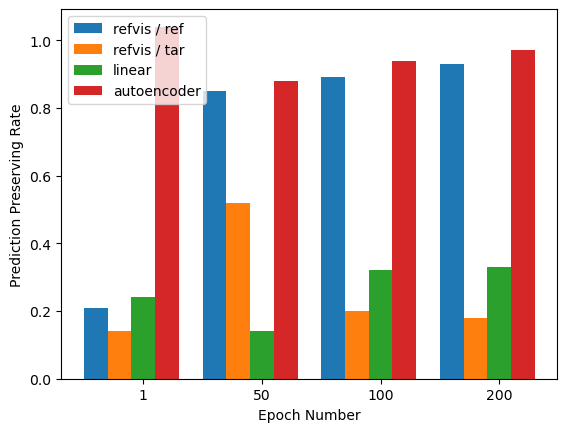

In [108]:
import numpy as np
import matplotlib.pyplot as plt

size = 4
name_list = ["1","50","100","200"]
x = np.arange(size)
#### timevis
a = [0.21,0.85,0.89,0.93]
#### tar in ref
d = [0.14,0.52,0.20,0.18]
#### linear
b = [0.24,0.14,0.32,0.33]
##### autoencoder
c = [1.04,0.88,0.94,0.97]


total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2
plt.xlabel('Epoch Number')
plt.ylabel('Prediction Preserving Rate')
plt.bar(x, a,  width=width, label='refvis / ref')
plt.bar(x + width, d,  width=width, label='refvis / tar')
plt.bar(x + 2 * width, b, width=width, label='linear',tick_label=name_list)
plt.bar(x + 3 * width, c, width=width, label='autoencoder')
plt.legend()
plt.show()

In [17]:
##### eval

import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 30

train_data = ref_train_data
embedding = projector.batch_project(REF_EPOCH, train_data)
val = evaluate_proj_nn_perseverance_knn(train_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, epoch))


Sat Apr  8 00:50:00 2023 Building RP forest with 16 trees
Sat Apr  8 00:50:01 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Apr  8 00:50:04 2023 Building RP forest with 16 trees
Sat Apr  8 00:50:04 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.81/30 in epoch 99


In [62]:
REF_EPOCH =1

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8640.71it/s]


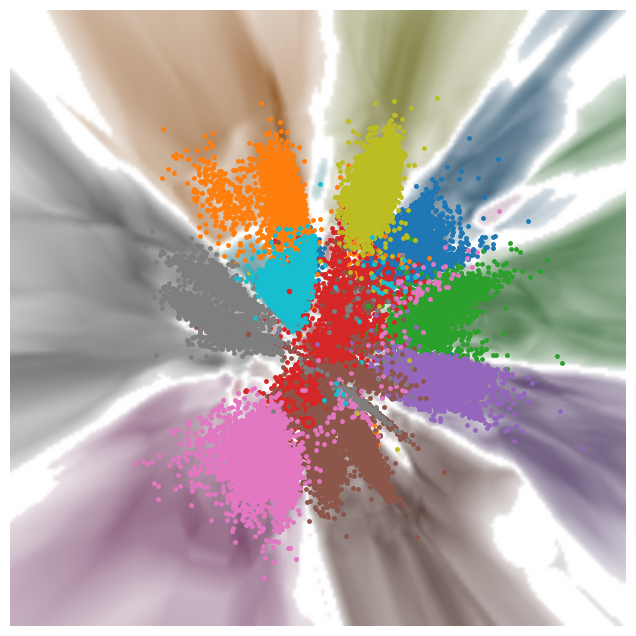

In [14]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.trans_visualizer import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(ref_provider, I,I, ref_provider.train_representation(REF_EPOCH), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7351.15it/s]


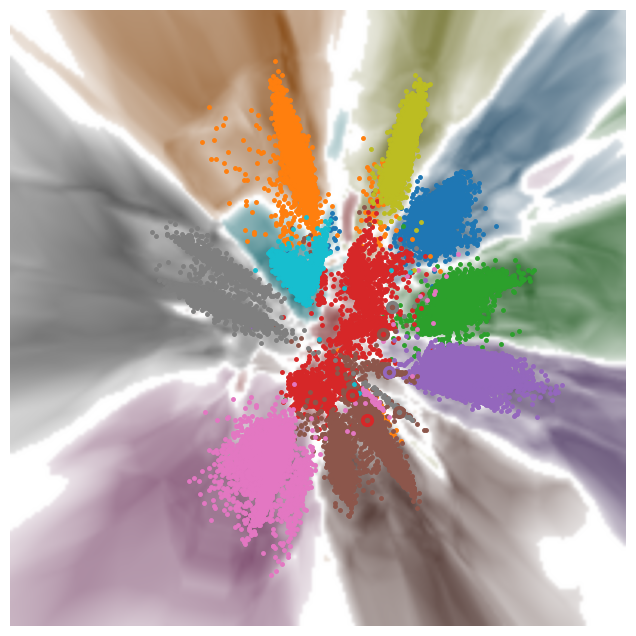

In [13]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [7]:
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/dropout_no_f_epoch_200.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

<All keys matched successfully>

In [26]:
encoded_B_Y = autoencoder.encoder(torch.Tensor(tar_features))

In [27]:
##### boundary knn eval

import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)


projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 15

train_data = encoded_B_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
########## reference_projector(autoencoder(target)) 2D vs target high dimensional
encoded_val = evaluate_proj_nn_perseverance_knn(tar_features, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for autoencoder: {:.2f}/{:d} in epoch {:d}".format(encoded_val, n_neighbors, REF_EPOCH))


Sun Apr  9 12:01:56 2023 Building RP forest with 9 trees
Sun Apr  9 12:01:57 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Sun Apr  9 12:01:57 2023 Building RP forest with 9 trees
Sun Apr  9 12:01:57 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 3.93/15 in epoch 100


In [28]:
REF_EPOCH

100

In [31]:
##### eval reference timevis visualize tar_representation

init_data = tar_features

embedding = projector.batch_project(REF_EPOCH, init_data)
val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for tar in ref vis: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, REF_EPOCH))


Sun Apr  9 12:02:43 2023 Building RP forest with 9 trees
Sun Apr  9 12:02:43 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Sun Apr  9 12:02:43 2023 Building RP forest with 9 trees
Sun Apr  9 12:02:43 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for tar in ref vis: 2.82/15 in epoch 100


In [32]:
##### eval reference timevis visualize tar_representation

init_data = ref_features

embedding = projector.batch_project(REF_EPOCH, init_data)
val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for ref in ref vis: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, REF_EPOCH))


Sun Apr  9 12:03:08 2023 Building RP forest with 9 trees
Sun Apr  9 12:03:08 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Sun Apr  9 12:03:08 2023 Building RP forest with 9 trees
Sun Apr  9 12:03:08 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for ref in ref vis: 3.41/15 in epoch 100


In [37]:
REF_EPOCH = 200
TAR_EPOCH = 200
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_2 = alignment_n.align_embeddings_batch(Y,X,train_steps=1000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 65502392.0 loss2 {tensor(0.7834, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8510, requires_grad=True)}
batch_idx 199,iteration 199, loss1 592.7222900390625 loss2 {tensor(0.5366, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4920, requires_grad=True)}
batch_idx 398,iteration 398, loss1 236.24374389648438 loss2 {tensor(0.3439, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4660, requires_grad=True)}
batch_idx 97,iteration 597, loss1 216.66461181640625 loss2 {tensor(0.3112, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4190, requires_grad=True)}
batch_idx 296,iteration 796, loss1 228.19483947753906 loss2 {tensor(0.3359, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4140, requires_grad=True)}
batch_idx 495,iteration 995, loss1 205.9328155517578 loss2 {tensor(0.2813, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3770, requires_grad=True)}


In [38]:
##### eval reference timevis visualize tar_representation
init_data = np.dot(tar_features,R_n_2.detach().numpy())

embedding = projector.batch_project(REF_EPOCH, init_data)
val = evaluate_proj_nn_perseverance_knn(tar_features, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for tar in ref vis: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, REF_EPOCH))


Sun Apr  9 12:05:23 2023 Building RP forest with 9 trees
Sun Apr  9 12:05:23 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Sun Apr  9 12:05:23 2023 Building RP forest with 9 trees
Sun Apr  9 12:05:24 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for tar in ref vis: 3.38/15 in epoch 200


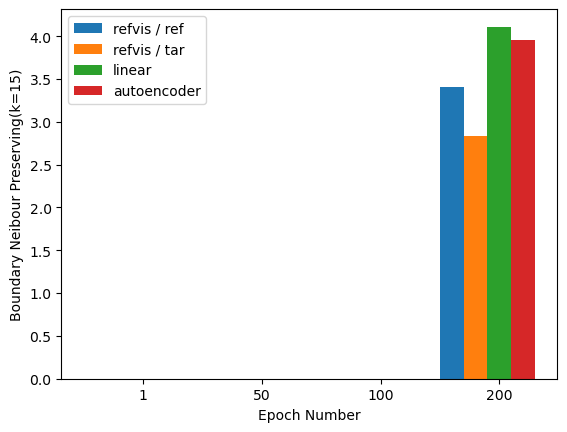

In [21]:
import numpy as np
import matplotlib.pyplot as plt

size = 4
name_list = ["1","50","100","200"]
x = np.arange(size)
#### timevis
a = [0,0,0,3.41]
#### tar in ref
d = [0,0,0,2.83]
#### linear
b = [0,0,0,4.11]
##### autoencoder
c = [0,0,0,3.96]


total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2
plt.xlabel('Epoch Number')
plt.ylabel('Boundary Neibour Preserving(k=15)')
plt.bar(x, a,  width=width, label='refvis / ref')
plt.bar(x + width, d,  width=width, label='refvis / tar')
plt.bar(x + 2 * width, b, width=width, label='linear',tick_label=name_list)
plt.bar(x + 3 * width, c, width=width, label='autoencoder')
plt.legend()
plt.show()